In [79]:
# data utils
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pywt

# data and feature engine
from cesium import datasets
from cesium import featurize


# model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# data

In [26]:
eeg = datasets.fetch_andrzejak()
eeg_df = pd.DataFrame(eeg)
eeg_df.head()

Loaded data from cached archive.


,times,measurements,classes,archive,header
0,"[0.0, 0.00576171875, 0.0115234375, 0.017285156...","[40.0, 48.0, 35.0, 5.0, -40.0, -54.0, -32.0, 6...",Z,/Users/zfwang/.local/datasets/andrzejak/andrze...,/Users/zfwang/.local/datasets/andrzejak/andrze...
1,"[0.0, 0.00576171875, 0.0115234375, 0.017285156...","[-56.0, -50.0, -64.0, -91.0, -135.0, -140.0, -...",Z,/Users/zfwang/.local/datasets/andrzejak/andrze...,/Users/zfwang/.local/datasets/andrzejak/andrze...
2,"[0.0, 0.00576171875, 0.0115234375, 0.017285156...","[-37.0, -22.0, -17.0, -24.0, -31.0, -20.0, -5....",Z,/Users/zfwang/.local/datasets/andrzejak/andrze...,/Users/zfwang/.local/datasets/andrzejak/andrze...
3,"[0.0, 0.00576171875, 0.0115234375, 0.017285156...","[-31.0, -43.0, -39.0, -39.0, -9.0, -5.0, 18.0,...",Z,/Users/zfwang/.local/datasets/andrzejak/andrze...,/Users/zfwang/.local/datasets/andrzejak/andrze...
4,"[0.0, 0.00576171875, 0.0115234375, 0.017285156...","[14.0, 26.0, 32.0, 25.0, 16.0, 8.0, 8.0, 12.0,...",Z,/Users/zfwang/.local/datasets/andrzejak/andrze...,/Users/zfwang/.local/datasets/andrzejak/andrze...


In [27]:
eeg_df.shape

(500, 5)

In [50]:
len(eeg["times"][0]), len(eeg["measurements"][0])

(4097, 4097)

# feature engine

## 类别型变量

In [28]:
eeg["classes"] = eeg["classes"].astype("U16")
eeg["classes"][np.logical_or(eeg["classes"] == "Z", eeg["classes"] == "O")] = "Normal"
eeg["classes"][np.logical_or(eeg["classes"] == "N", eeg["classes"] == "F")] = "Interictal"
eeg["classes"][eeg["classes"] == "S"] = "Ictal"

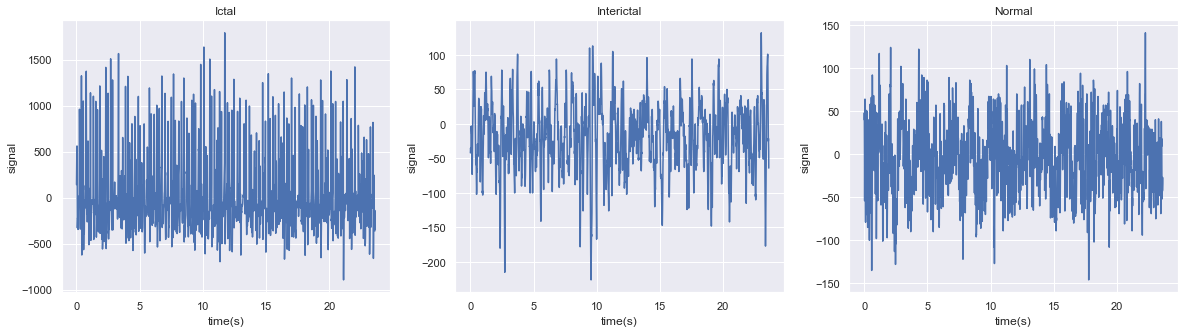

In [41]:
fig, axes = plt.subplots(1, len(np.unique(eeg["classes"])), sharey = False, figsize = (20, 5))
for label, ax in zip(np.unique(eeg["classes"]), axes):
    i = np.where(eeg["classes"] == label)[0][0]
    ax.plot(eeg["times"][i], eeg["measurements"][i])
    ax.set_xlabel("time(s)")
    ax.set_ylabel("signal")
    ax.set_title(label)
plt.show()

## 特征构造

In [62]:
# cesium features
features_to_use = [
    "amplitude",
    "percent_beyond_1_std",
    "maximum",
    "max_slope",
    "median",
    "median_absolute_deviation",
    "percent_close_to_median",
    "minimum",
    "skew",
    "std",
    "weighted_average",
]


# udf features
def mean_signal(t, m, e):
    return np.mean(m)

def std_signal(t, m, e):
    return np.std(m)

def mean_square_signal(t, m, e):
    return np.mean(m ** 2)

def abs_diffs_signal(t, m, e):
    return np.sum(np.abs(np.diff(m)))

def skew_signal(t, m, e):
    return scipy.stats.skew(m)

guo_features = {
    "mean": mean_signal,
    "std": std_signal,
    "mean2": mean_square_signal,
    "abs_diffs": abs_diffs_signal,
    "skew": skew_signal,
}

# 多通道时间序列特征
n_channels = 5
eeg["dwts"] = [
    pywt.wavedec(m, pywt.Wavelet("db1"), level = n_channels - 1)
    for m in eeg["measurements"]
]

In [55]:
# feature engine
feature_set_cesium = featurize.featurize_time_series(
    times = eeg["times"],
    values = eeg["measurements"],
    errors = None,
    features_to_use = features_to_use,
)
print(feature_set_cesium.head())
print(feature_set_cesium.shape)

feature amplitude percent_beyond_1_std maximum     max_slope median  \
channel         0                    0       0             0      0   
0           143.5             0.327313   141.0  11107.796610   -4.0   
1           211.5             0.290212   169.0  20653.559322  -51.0   
2           165.0             0.302660   184.0  13537.627119   13.0   
3           171.5             0.300952   162.0  17008.813559   -4.0   
4           170.0             0.305101   152.0  13016.949153  -18.0   

feature median_absolute_deviation percent_close_to_median minimum      skew  \
channel                         0                       0       0         0   
0                            28.0                0.505004  -146.0  0.032805   
1                            32.0                0.640469  -254.0 -0.092715   
2                            31.0                0.515987  -146.0 -0.004100   
3                            31.0                0.541128  -181.0  0.063678   
4                           

In [58]:
# udf features
feature_set_guo = featurize.featurize_time_series(
    times = eeg["times"],
    values = eeg["measurements"],
    errors = None,
    features_to_use = list(guo_features.keys()),
    custom_functions = guo_features,
)
print(feature_set_guo.head())
print(feature_set_guo.shape)

feature       mean        std        mean2 abs_diffs      skew
channel          0          0            0         0         0
0        -4.132048  40.411000  1650.122773   46948.0  0.032805
1       -52.444716  48.812668  5133.124725   61118.0 -0.092715
2        12.705150  47.144789  2384.051989   51269.0 -0.004100
3        -3.992433  47.072316  2231.742495   75014.0  0.063678
4       -17.999268  44.910958  2340.967781   52873.0  0.142753
(500, 5)


In [64]:
feature_set_dwt = featurize.featurize_time_series(
    times = None,
    values = eeg["dwts"],
    errors = None,
    features_to_use = list(guo_features.keys()),
    custom_functions = guo_features,
)
print(feature_set_dwt.head())
print(feature_set_dwt.shape)

feature        mean                                                 std  \
channel           0         1         2         3         4           0   
0        -17.080739 -6.067121 -0.979336  0.154634  0.035545  112.473774   
1       -210.210117 -3.743191  0.511377  0.057561 -0.024847  119.836067   
2         51.831712  0.714981  0.247418 -0.101951  0.007937  134.809626   
3        -15.429961  9.348249 -0.099243 -0.228293  0.181522  104.420503   
4        -71.982490 -3.787938 -0.183324 -0.034146 -0.048314  124.012203   

feature                                              ... abs_diffs            \
channel          1          2          3          4  ...         0         1   
0        72.970862  48.167301  25.774846  10.154899  ...  25127.00  18056.00   
1        92.777487  67.005780  33.957464  13.673398  ...  28742.00  25226.00   
2        78.294247  60.275759  28.088980  11.246134  ...  28284.75  19826.25   
3        89.999242  67.249397  35.929621  16.366747  ...  24848.25  25715.

# model

In [68]:
train_idx, test_idx = train_test_split(
    np.arange(len(eeg["classes"])),
    random_state = 0,
)
train_idx, test_idx

(array([239,  59, 406, 391, 411, 485, 229, 297,  55, 293, 490, 458, 457,
        453, 186, 194,  52,  74,  26, 488,   4, 318, 331, 245,   5, 141,
        383, 135, 493, 122,  22,  68,  20, 382,  14, 278, 225,  64, 381,
        231,  81, 401, 302, 499, 471, 455, 160, 478, 364, 496, 206, 319,
         51, 306, 452, 332, 164, 106, 481,  63, 344, 427, 439, 320,  89,
        312, 450,  93, 298, 459, 308, 395,  92,  18, 198, 145, 158, 150,
        479, 167, 255, 230, 422,  66, 309, 253, 140, 101, 433,   2, 408,
         17, 146, 249, 263,  30, 114, 247, 103, 405, 310, 176, 246, 116,
        168, 415, 120, 261, 112, 360, 435, 282, 136, 190, 347, 181, 126,
        281, 252, 407, 393, 354, 232, 133,  33, 476, 162,  34,  44,  97,
         85,  61, 199, 268, 218,  73,  35, 303,  29, 361, 392, 443, 217,
         27, 399, 380, 156, 429, 345, 138, 212, 104, 350, 346, 351, 215,
        385, 189, 214, 204, 234, 259,  67,  24, 216, 223, 129, 111, 166,
        417, 394,  40, 274, 357,  79, 313, 315,  13

In [76]:
model_cesium = RandomForestClassifier(n_estimators = 128, max_features = "auto", random_state = 0)
model_cesium.fit(feature_set_cesium.iloc[train_idx], eeg["classes"][train_idx])

/Users/zfwang/.pyenv/versions/ts/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


RandomForestClassifier(n_estimators=128, random_state=0)

In [77]:
model_guo = KNeighborsClassifier(n_neighbors = 3)
model_guo.fit(feature_set_guo.iloc[train_idx], eeg["classes"][train_idx])

/Users/zfwang/.pyenv/versions/ts/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


KNeighborsClassifier(n_neighbors=3)

In [78]:
model_dwt = KNeighborsClassifier(n_neighbors = 3)
model_dwt.fit(feature_set_dwt.iloc[train_idx], eeg["classes"][train_idx])

/Users/zfwang/.pyenv/versions/ts/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


KNeighborsClassifier(n_neighbors=3)

# model predict

In [83]:
preds_cesium = model_cesium.predict(feature_set_cesium)
preds_guo = model_guo.predict(feature_set_guo)
preds_dwt = model_dwt.predict(feature_set_dwt)

print("Built-in cesium features: training accuracy={:.2%}, test accuracy={:.2%}".format(
    accuracy_score(preds_cesium[train_idx], eeg["classes"][train_idx]),
    accuracy_score(preds_cesium[test_idx], eeg["classes"][test_idx])
))
print("Guo et al. features: training accuracy={:.2%}, test accuracy={:.2%}".format(
    accuracy_score(preds_guo[train_idx], eeg["classes"][train_idx]),
    accuracy_score(preds_guo[test_idx], eeg["classes"][test_idx])
))
print("Wavelet transform features: training accuracy={:.2%}, test accuracy={:.2%}".format(
    accuracy_score(preds_dwt[train_idx], eeg["classes"][train_idx]),
    accuracy_score(preds_dwt[test_idx], eeg["classes"][test_idx])
))

Built-in cesium features: training accuracy=100.00%, test accuracy=83.20%
Guo et al. features: training accuracy=92.80%, test accuracy=83.20%
Wavelet transform features: training accuracy=97.87%, test accuracy=95.20%


/Users/zfwang/.pyenv/versions/ts/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/Users/zfwang/.pyenv/versions/ts/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/Users/zfwang/.pyenv/versions/ts/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
